(1080, 1920, 3)

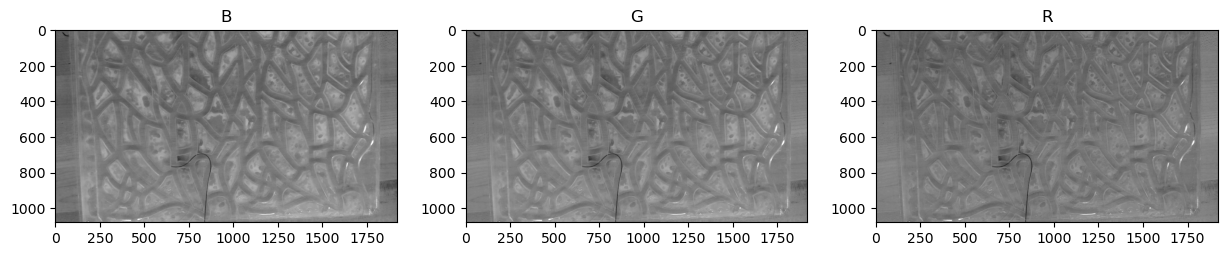

In [147]:
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import cv2

image = cv2.imread("Data/Datasets/RigidModelVideo-11-21/11-21-1-clip2/frame1069.jpg")
# image = cv2.imread("../../Data/Datasets/RigidModelVideo-11-21/11-21-1-clip2/frame0478.jpg")

# image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
# plt.imshow(image, cmap='gray')
f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 4))
ax1.imshow(image[:, :, 0], cmap='gray')
ax1.set_title('B')
ax2.imshow(image[:, :, 1], cmap='gray')
ax2.set_title('G')
ax3.imshow(image[:, :, 2], cmap='gray')
ax3.set_title('R')
image.shape

Text(0.5, 1.0, 'R')

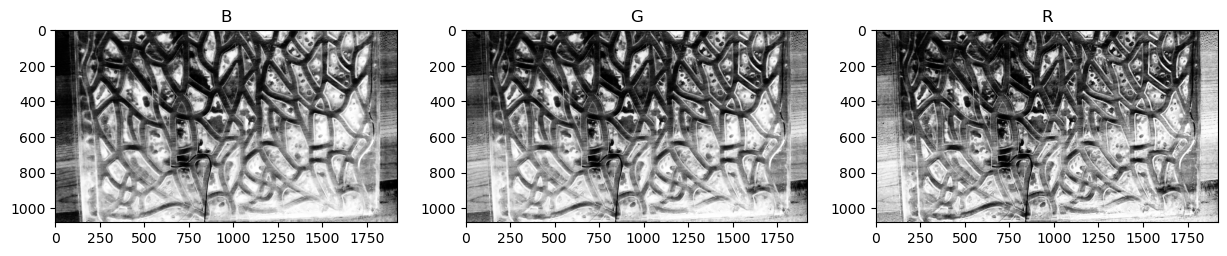

In [148]:
image_b = image[:, :, 0]
image_g = image[:, :, 1]
image_r = image[:, :, 2]
image_b_e = cv2.equalizeHist(image_b)
image_g_e = cv2.equalizeHist(image_g)
image_r_e = cv2.equalizeHist(image_r)
_, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 4))
ax1.imshow(image_b_e, cmap='gray')
ax1.set_title('B')
ax2.imshow(image_g_e, cmap='gray')
ax2.set_title('G')
ax3.imshow(image_r_e, cmap='gray')
ax3.set_title('R')


Text(0.5, 1.0, 'R')

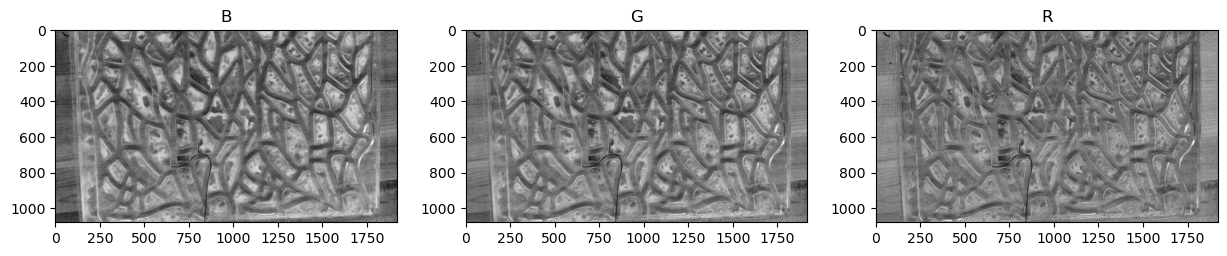

In [149]:
clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
image_b_e = clahe.apply(image_b)
image_g_e = clahe.apply(image_g)
image_r_e = clahe.apply(image_r)

_, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 4))
ax1.imshow(image_b_e, cmap='gray')
ax1.set_title('B')
ax2.imshow(image_g_e, cmap='gray')
ax2.set_title('G')
ax3.imshow(image_r_e, cmap='gray')
ax3.set_title('R')

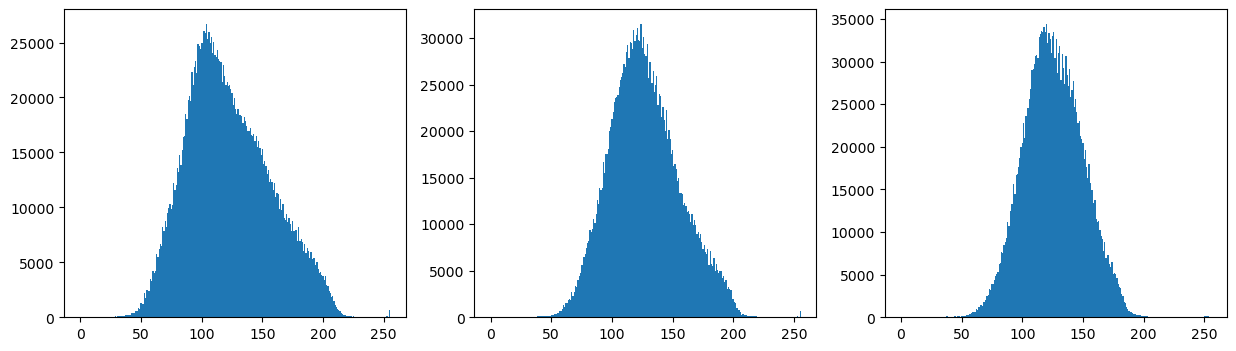

In [150]:
def plot_histogram(image, ax):
    hst, _ = np.histogram(image, bins=256, range=(0, 256))
    _ = ax.bar(np.arange(256), hst, width=1, edgecolor='none')

_, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 4))

plot_histogram(image_b_e, ax1)
plot_histogram(image_g_e, ax2)
plot_histogram(image_r_e, ax3)


126
102
84
67
48
131
103
85
70
52
128
95
76
62
48


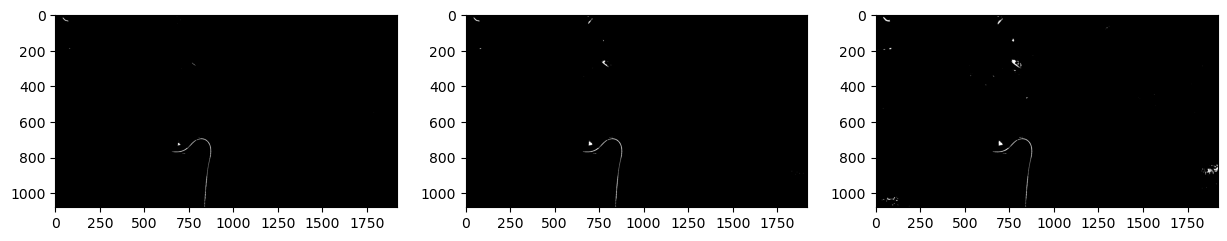

In [151]:
# B is better for thresholding
from skimage.filters import threshold_otsu

def recursive_otsu(image, count=5):
    threshold = threshold_otsu(image)
    print(threshold)
    binary = image[image < threshold]
    if count > 0:
        return recursive_otsu(binary, count-1)
    else:
        return threshold

_, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 4))
threshold = recursive_otsu(image_r_e, 4)
ax1.imshow(image_r_e < threshold, cmap='gray')
threshold = recursive_otsu(image_g_e, 4)
ax2.imshow(image_g_e < threshold, cmap='gray')
threshold = recursive_otsu(image_b_e, 4)
ax3.imshow(image_b_e < threshold, cmap='gray')

124
112
99
73
131
117
105
81
129
112
100
76


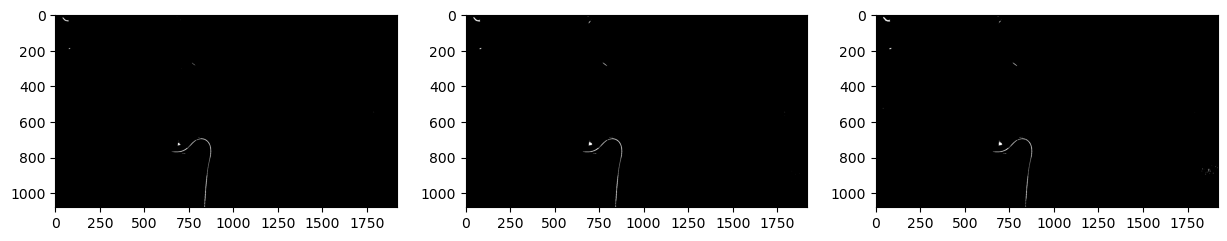

In [152]:
_, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 4))
threshold = recursive_otsu(image_r, 3)
ax1.imshow(image_r < threshold, cmap='gray')
threshold = recursive_otsu(image_g, 3)
ax2.imshow(image_g < threshold, cmap='gray')
threshold = recursive_otsu(image_b, 3)
ax3.imshow(image_b < threshold, cmap='gray')

dtype('uint8')

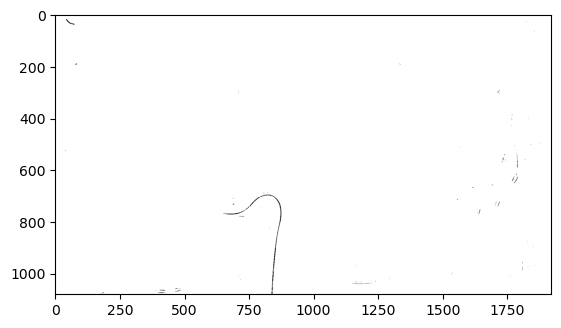

In [153]:
bin = cv2.adaptiveThreshold(image_r, 80, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, blockSize=33, C=30)
plt.imshow(bin, cmap='gray')
bin.dtype

In [154]:

def adaptive_threshold(image, maxValue, block_size, C, max_block_mean=120):
    new_image = np.copy(image)
    new_image[new_image > max_block_mean] = max_block_mean
    return cv2.adaptiveThreshold(new_image, maxValue, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, blockSize=block_size, C=C)

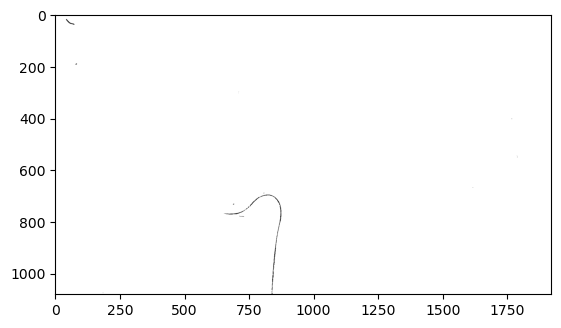

In [155]:
bin = adaptive_threshold(image_r, 80, block_size=33, C=30, max_block_mean=110)
plt.imshow(bin, cmap='gray')

In [156]:
mask = np.invert(bin.astype(bool))
mask.sum()

1593

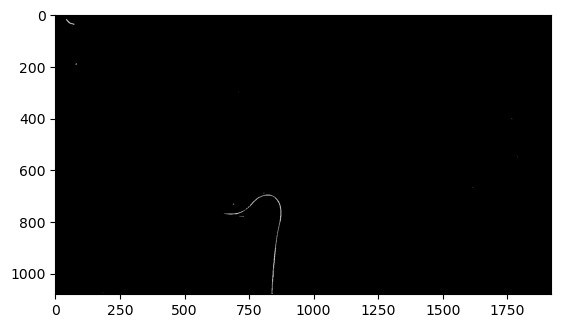

In [157]:
# morphological operations:

# tmp = cv2.morphologyEx(mask.astype(np.uint8), cv2.MORPH_OPEN, cv2.getStructuringElement(cv2.MORPH_RECT, (3, 3)))
tmp = cv2.morphologyEx(mask.astype(np.uint8), cv2.MORPH_CLOSE, cv2.getStructuringElement(cv2.MORPH_RECT, (7, 7)))
# tmp = cv2.morphologyEx(tmp, cv2.MORPH_DILATE, cv2.getStructuringElement(cv2.MORPH_RECT, (3, 3)))
plt.imshow(tmp, cmap='gray')

[10 13]
[10 13]


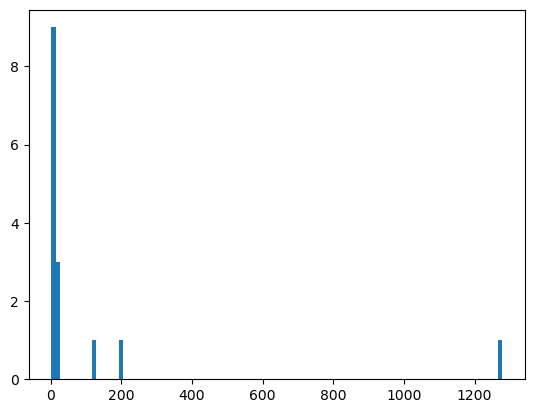

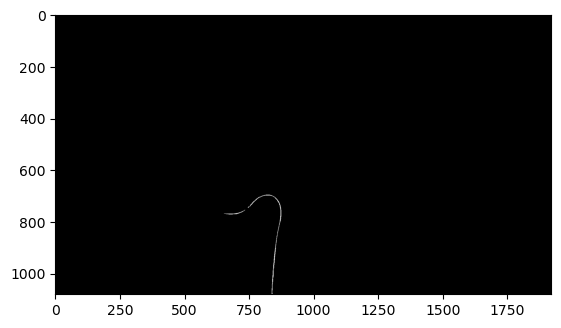

In [158]:
# Connected components analysis:

num, labeled, stats, centroids = cv2.connectedComponentsWithStats(tmp, connectivity=8)

sizes = stats[1:, -1]
plt.hist(sizes, bins=100)

labels = np.where(sizes >= threshold_otsu(sizes))[0] + 1
print(labels)
# Only keep the top 2 largest connected component:
plt.figure(2)
# labels = np.argsort(stats[:, -1])[-3:-1]
print(labels)
plt.imshow(np.isin(labeled, labels), cmap='gray')

mask = np.isin(labeled, labels).astype(np.uint8)


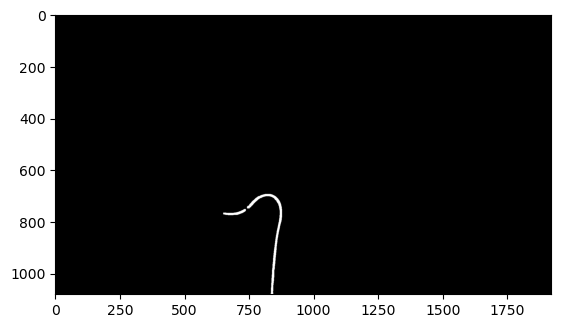

In [159]:

# Morphological skeletonization:
from skimage.morphology import skeletonize

mask = cv2.morphologyEx(mask, cv2.MORPH_DILATE, cv2.getStructuringElement(cv2.MORPH_RECT, (7, 7)))
plt.imshow(mask, cmap='gray')


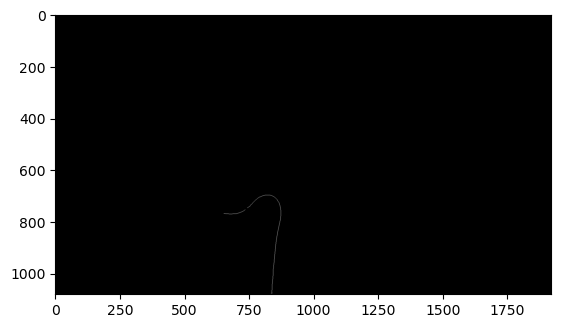

In [160]:
skeleton = skeletonize(mask)
plt.imshow(skeleton, cmap='gray')

array([[ 747,  744],
       [1076,  841],
       [1078,  836]])

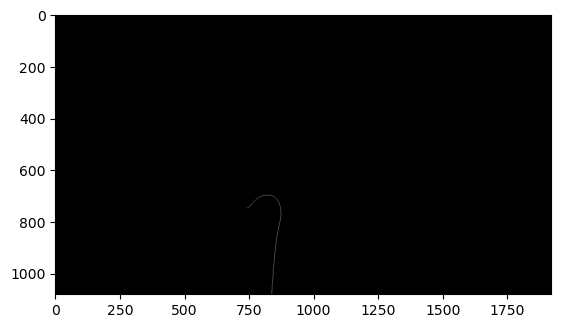

In [161]:
# Find the start and end point of the skeleton is like finding the point with only one neighbor:

def find_endpoint(skeleton):
    connectivity = find_connectivity(skeleton)
    # print(np.unique(connectivity, return_counts=True))
    return np.argwhere(connectivity == 2)

def find_connectivity(binary_image):
    result = np.zeros_like(binary_image, dtype=np.uint8)
    for [i, j] in np.argwhere(binary_image):
        conn_count = 0
        for ii in range(i-1, i+2):
            for jj in range(j-1, j+2):
                if binary_image[ii, jj]:
                    conn_count += 1
        result[i, j] = conn_count
    return result

_, labeled, stats, _ = cv2.connectedComponentsWithStats(skeleton.astype(np.uint8), connectivity=8)
main_skeleton = np.isin(labeled, np.argsort(stats[:, -1])[-2]).astype(np.uint8)
plt.imshow(main_skeleton, cmap='gray')
find_endpoint(main_skeleton)
#OK, we are all set.


/home/zzy/miniconda3/envs/imaging/lib/python3.11/site-packages/fil_finder/filfinder2D.py:142: UserWarning: No beam width given. Using 0 pixels.
  warnings.warn("No beam width given. Using 0 pixels.")
/home/zzy/miniconda3/envs/imaging/lib/python3.11/site-packages/astropy/units/quantity.py:666: RuntimeWarning: divide by zero encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/home/zzy/miniconda3/envs/imaging/lib/python3.11/site-packages/astropy/units/quantity.py:666: RuntimeWarning: invalid value encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/home/zzy/miniconda3/envs/imaging/lib/python3.11/site-packages/fil_finder/filfinder2D.py:296: UserWarning: Using inputted mask. Skipping creation of anew mask.
  warnings.warn("Using inputted mask. Skipping creation of a"
/home/zzy/miniconda3/envs/imaging/lib/python3.11/site-packages/fil_finder/filament.py:326: UserWarning: Graph pruning reached max iterations.

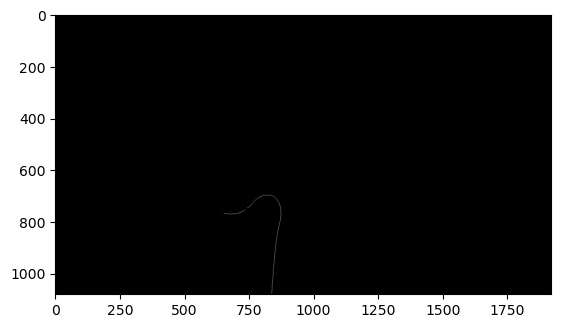

In [162]:
# Now we find the largest branch of skeleton as the final result: 
import os
os.environ['ASTROPY_SKIP_CONFIG_UPDATE'] = '1'
from fil_finder import FilFinder2D
from astropy import units as u

fil = FilFinder2D(skeleton.astype(np.uint8), distance=250 * u.pc, mask=skeleton.astype(np.uint8))
fil.preprocess_image(flatten_percent=85)
fil.create_mask(border_masking=True, verbose=False,use_existing_mask=True)
fil.medskel(verbose=False)
fil.analyze_skeletons(branch_thresh=40* u.pix, skel_thresh=10 * u.pix, prune_criteria='length')
plt.imshow(fil.skeleton_longpath, cmap='gray')


In [163]:
print(fil.end_pts)
endpoint_bound_frac = 0.05
h, w = 1080, 1920
endpoint_boundary = (h * endpoint_bound_frac, w * endpoint_bound_frac, h * (1-endpoint_bound_frac), w * (1-endpoint_bound_frac))
for p in fil.end_pts[1]:
    print(p)
    print(endpoint_boundary[0] < p[0] < endpoint_boundary[2])
    print(endpoint_boundary[1] < p[1] < endpoint_boundary[3])
endpoint_boundary

[[(747, 744), (1078, 836)], [(754, 736), (769, 653)]]
(754, 736)
True
True
(769, 653)
True
True


(54.0, 96.0, 1026.0, 1824.0)

array([[ 747,  744],
       [ 754,  736],
       [ 769,  653],
       [1078,  836]])

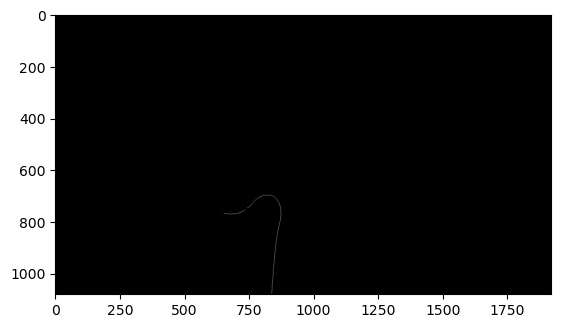

In [164]:
sl = fil.skeleton_longpath.astype(np.uint8)
_, labeled, stats, centroids = cv2.connectedComponentsWithStats(sl, connectivity=8)

endpoints = find_endpoint(sl)
endpoints_labels = [labeled[p[0], p[1]] for p in endpoints]
eligiblity = [endpoint_boundary[0] < p[0] < endpoint_boundary[2] and endpoint_boundary[1] < p[1] < endpoint_boundary[3] for p in endpoints]

for label in np.unique(endpoints_labels):
    eligible_count = np.sum(np.logical_and(eligiblity, endpoints_labels == label))
    if eligible_count == 0:
        sl[labeled == label] = 0


plt.imshow(sl, cmap='gray')
endpoints

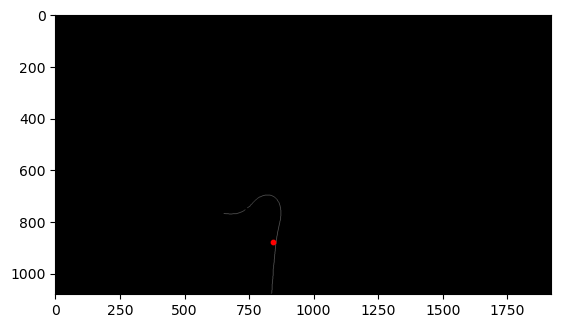

In [165]:
plt.imshow(fil.skeleton_longpath, cmap='gray')
plt.scatter([841], [877], s=10, c='r')

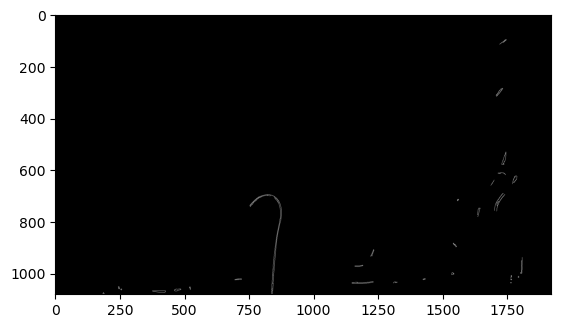

In [166]:
# image = image_r
# Gradient-based: Guidewire has strong gradient
l = cv2.Laplacian(image, cv2.CV_64F)
sx = cv2.Sobel(image, cv2.CV_64F, 1, 0, ksize=3)
sy = cv2.Sobel(image, cv2.CV_64F, 0, 1, ksize=3)
c = cv2.Canny(image, 100, 400)
# plt.imshow(np.abs(l), cmap='gray')
# plt.imshow(np.abs(sy + sx), cmap='gray')
plt.imshow(c, cmap='gray')

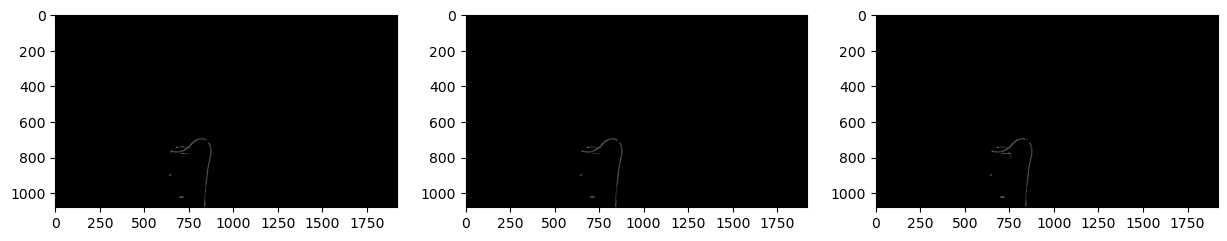

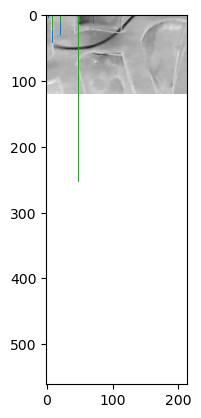

In [167]:
# Do patched canny to supress brighter region gradient
from skimage.util import view_as_windows

def image_patch(image, patch_size=10):
    patch_w = image.shape[1] // patch_size
    patch_h = image.shape[0] // patch_size
    patches = np.zeros((patch_size, patch_size, patch_h, patch_w), dtype=np.uint8)
    for i in range(patch_size):
        for j in range(patch_size):
            patches[i, j] = image[i * patch_h: (i + 1) * patch_h, j * patch_w: (j + 1) * patch_w]       
    return np.array(patches), patch_w, patch_h



def patch_canny(image, patch_size=9, threshold1=100, threshold2=400, drop_intensity_thresh=100, drop_size=100):
    patches, patch_w, patch_h = image_patch(image, patch_size)
    canny = np.zeros_like(image)
    inspect = []
    for i in range(patches.shape[0]):
        for j in range(patches.shape[1]):
            inspect.append((patches[i, j] < drop_intensity_thresh).sum())
            area_size = (patches[i, j] < drop_intensity_thresh).sum()
            if area_size > drop_size:
                canny[i * patch_h: (i + 1) * patch_h, j * patch_w: (j + 1) * patch_w] = cv2.Canny(patches[i, j], threshold1, threshold2)
    plt.imshow(patches[np.argmax(inspect)//patch_size, np.argmax(inspect)%patch_size], cmap='gray')
    plt.figure(2)
    plt.bar(range(len(inspect)), inspect)
    return canny

_, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 4))
patched_canny = patch_canny(image_b, patch_size=9, threshold1=50, threshold2=300, drop_intensity_thresh=70,drop_size=50)
ax1.imshow(patched_canny, cmap='gray')
patched_canny = patch_canny(image_g, patch_size=9, threshold1=50, threshold2=300, drop_intensity_thresh=70,drop_size=50)
ax2.imshow(patched_canny, cmap='gray')
patched_canny = patch_canny(image_r, patch_size=9, threshold1=50, threshold2=300, drop_intensity_thresh=70,drop_size=50)
ax3.imshow(patched_canny, cmap='gray')


In [168]:
# Supress gradient in bright region by modifying gradient selection process in canny

def canny_with_hueristic(image, threshold1, threshold2, ksize=5, edge_neighbor_intensity_thresh=100):
    blurred = cv2.GaussianBlur(image, (ksize, ksize), 0)
    gx = cv2.Scharr(blurred, cv2.CV_64F, 1, 0)

In [169]:
from guidewire_in_rigid_model import segment_guidewire

segmentation, endpointsm, interm = segment_guidewire(image)
plt.imshow(segmentation, cmap='gray')

ModuleNotFoundError: No module named 'common_configs'